In [ ]:
import cv2
import os
import sys
import numpy
import fingerprint_enhancer
import matplotlib.pyplot as plt
# from enhance import image_enhance
from skimage.morphology import skeletonize, thin

In [ ]:
def get_descriptors(img_path):
	img = cv2.imread(img_path, 0)
	clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
	img = clahe.apply(img)
	# img = image_enhance.image_enhance(img)
	# img = fingerprint_enhancer.enhance_Fingerprint(img)
	img = numpy.array(img, dtype=numpy.uint8)
	# Threshold
	ret, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
	# Normalize to 0 and 1 range
	img[img == 255] = 1

	#Thinning
	skeleton = skeletonize(img)
	skeleton = numpy.array(skeleton, dtype=numpy.uint8)
	# skeleton = removedot(skeleton)
	# Harris corners
	harris_corners = cv2.cornerHarris(img, 3, 3, 0.04)
	harris_normalized = cv2.normalize(harris_corners, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32FC1)
	threshold_harris = 125
	# Extract keypoints
	keypoints = []
	for x in range(0, harris_normalized.shape[0]):
		for y in range(0, harris_normalized.shape[1]):
			if harris_normalized[x][y] > threshold_harris:
				keypoints.append(cv2.KeyPoint(y, x, 1))
	# Define descriptor
	orb = cv2.ORB_create()
	# Compute descriptors
	_, des = orb.compute(img, keypoints)
	return des

In [ ]:
def Matching_des(d1,d2):
  bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
  matches = sorted(bf.match(d1, d2), key= lambda match:match.distance)

  score = 0
  for match in matches:
    score += match.distance

  return 100-score/(len(matches)+1)

In [ ]:
def recog(img_path,descs,score_threshold):
	test_desc = get_descriptors(img_path)
	scores = {}
	for imp, d in descs.items():
		scores[imp]=Matching_des(test_desc,d)
	scores = sorted(scores.items(), key=lambda x: -1*x[1])
	print(scores[0][0][0:3],os.path.basename(img_path)[0:3],scores[0][1])
	if scores[0][1]>=score_threshold:
		return True
	return False

In [19]:
db = "fvc_ddqn/"
test = "fvc2002/"
descs = {}
for i in os.listdir(db):
    img_path = os.path.join(db,i)
    d=get_descriptors(img_path)
    if d is None:
        continue
    descs[i.split(".")[0]]=d

In [8]:
descs

{'101_2': array([[172,  27, 224, ..., 238,  84,  64],
        [ 41,  25, 228, ..., 239,  80,  16],
        [224, 147,  73, ...,  34, 138, 164],
        ...,
        [133, 148,  88, ...,  33,  41, 128],
        [129, 145,  88, ...,  33,  43, 128],
        [ 69,  84,  84, ...,  17,  33,   2]], dtype=uint8),
 '101_3': array([[ 80,  16, 132, ...,   0,   0,  32],
        [  0,   8,   4, ...,  99,   0, 144],
        [  1,  12,   4, ...,  65,   0, 152],
        ...,
        [  1,  21,  82, ...,   2,  35, 130],
        [  1,  49,  18, ...,   0, 163, 138],
        [  0,  64, 162, ...,  24,  21, 234]], dtype=uint8),
 '101_4': array([[ 96, 166,  25, ...,   0,  22,   8],
        [240, 162,  49, ...,   0,  22,   8],
        [208, 160, 179, ...,   0,   6,   8],
        ...,
        [ 36,  31, 104, ..., 122,  84, 194],
        [ 36,  12,  72, ..., 234,  80, 212],
        [ 38,  29, 104, ..., 122,  84, 214]], dtype=uint8),
 '101_5': array([[  0,   8,   5, ..., 153,   4,  40],
        [ 64,   8,  69, .

In [6]:
os.listdir(db)

[]

In [20]:
t=0
f=0
for i in os.listdir(test):
	if recog(os.path.join(test,i),descs,70):
		t+=1
	else:
		f+=1

# print(t,f)

101 101 89.5989010989011
101 101 79.89430894308943
101 101 89.53284671532847
101 101 87.83206106870229
101 101 91.52820512820513
101 101 92.77314814814815
101 101 91.24302788844622
101 101 90.38741721854305
102 102 93.98657718120805
102 102 89.94634146341464
102 102 88.60773480662984
102 102 87.93865030674847
102 102 90.31410256410257
102 102 89.55109489051095
102 102 88.16504854368932
102 102 92.74728260869566
103 103 83.3076923076923
103 103 91.38970588235294
103 103 90.5909090909091
103 103 95.45901639344262
103 103 92.22393822393822
103 103 88.61538461538461
103 103 90.60747663551402
103 103 90.06849315068493
104 104 93.61
104 104 91.89102564102564
104 104 91.51408450704226
104 104 90.5234375
109 104 87.68518518518519
104 104 90.16901408450704
104 104 86.19402985074626
104 104 93.47586206896551
105 105 92.3896103896104
105 105 91.84745762711864
105 105 87.70138888888889
105 105 90.1048951048951
109 105 91.09302325581396
105 105 90.49765258215962
105 105 88.66319444444444
105 105 91

In [21]:
t,f

(76, 4)

In [30]:
far = {}
for thresh in range(60,105,5):
    t=0
    f=0
    for i in os.listdir(test):
        if recog(os.path.join(test,i),descs,thresh):
            t+=1
        else:
            f+=1
    far[thresh]=[t,f]

14 14 90.09022556390977
65 65 79.46534653465346
84 84 81.437125748503
47 47 94.41923076923077
03 03 91.33333333333333
54 54 91.168458781362
61 61 84.92148760330579
76 76 87.24475524475524
63 63 91.43046357615894
33 33 87.43125
23 23 76.27464788732394
42 42 90.48245614035088
05 05 83.99633699633699
31 31 91.57915057915058
68 68 75.16756756756757
73 73 87.15789473684211
94 94 85.54978354978356
50 50 85.37209302325581
28 28 78.7295918367347
26 26 91.74177215189873
80 80 84.65527950310559
54 54 91.0925925925926
01 01 91.58938547486034
06 06 87.0
33 33 93.68032786885246
26 26 92.07487922705315
01 01 91.925
79 79 80.24603174603175
95 95 81.76530612244898
43 43 75.79591836734694
98 98 88.38732394366197
23 23 76.3840579710145
65 65 78.05405405405405
51 51 69.28571428571428
78 78 80.77702702702703
36 36 95.61631419939577
57 57 94.01063829787233
27 27 79.99159663865547
69 69 86.75
52 52 89.68817204301075
66 66 92.305
73 73 85.0
37 37 89.96407185628743
59 59 87.53179190751445
47 47 95.61052631578

In [26]:
print(t,f)

61 39


In [33]:
x = far.keys()
y = [i[1]/(i[0]+i[1]) for i in far.values()]

In [32]:
x

dict_keys([60, 65, 70, 75, 80, 85, 90, 95, 100])

In [34]:
y

[0.0, 0.0, 0.01, 0.02, 0.19, 0.39, 0.71, 0.96, 1.0]

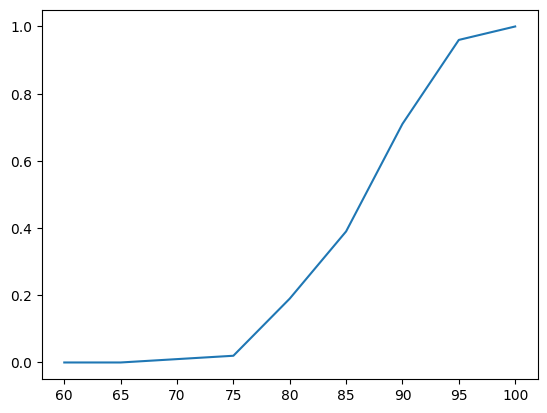

In [35]:
plt.plot(x,y)
plt.show()